In [ ]:
#  Data selection and preprocessing
# ------------------------------------------------------------------------

# 1. Install & import dependencies
!pip install ONE-api brainbox ibllib --quiet

import numpy as np
import pandas as pd
from one.api import ONE
from one.remote.aws import s3_download_file
from pathlib import Path
from scipy import sparse

# 2. ONE setup
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE()

# 3. Utility functions (adapted from tutorial)
def download_data(event: str):
    assert event in ('stimOn','firstMove','feedback')
    fname = f'data_{event}.zip'
    remote = f'sample_data/Neuromatch/{fname}'
    local_dir = Path(one.cache_dir) / 'Neuromatch'
    local_dir.mkdir(parents=True, exist_ok=True)
    target = Path(one.cache_dir) / 'Neuromatch' / fname
    s3_download_file(remote, target)
    import zipfile
    with zipfile.ZipFile(target, 'r') as z:
        z.extractall(local_dir)

def load_metadata(event: str):
    base = Path(one.cache_dir) / 'Neuromatch' / f'data_{event}'
    meta = {}
    meta['clusters'] = pd.read_parquet(base/'clusters.pqt')
    meta['trials']   = pd.read_parquet(base/'trials.pqt')
    meta['sessions'] = pd.read_parquet(base/'sessions.pqt')
    meta['times']    = np.load(base/'t.npy')
    meta['nbins']    = meta['times'].size
    meta['dt']       = np.median(np.diff(meta['times']))
    meta['data_dir'] = base
    return meta

def load_psth(pid: str, meta: dict):
    arr = sparse.load_npz(meta['data_dir']/f'{pid}.npz').toarray()
    return arr.reshape(arr.shape[0], -1, meta['nbins']) / meta['dt']

# 4. Download & load stimulus-aligned data
download_data('stimOn')
meta = load_metadata('stimOn')

# 5. Select trial subsets: 100% vs 0% contrast, by choice side
trials = meta['trials']
# compute signed contrast
trials['contrast'] = (trials['contrastLeft'].fillna(0) + trials['contrastRight'].fillna(0)) * 100

# high-contrast trials (100%) & zero-contrast (0%)
high = trials[trials['contrast'] == 100]
zero = trials[trials['contrast'] == 0]

# separate left/right
conds = {
    'sensory_left':  high[high['choice'] == -1],
    'sensory_right': high[high['choice'] ==  1],
    'memory_left':   zero[zero['choice'] == -1],
    'memory_right':  zero[zero['choice'] ==  1]
}

# 6. Regions of interest
regions = ['VISp','RSP','CA1','MOp']  # visual, retrosplenial, hippocampus, motor

# 7. Gather per-region average PSTHs, handling empty conditions
region_psth = {}
for reg in regions:
    # clusters in region
    clusts = meta['clusters']
    reg_clusts = clusts[clusts['acronym'] == reg]
    pids = reg_clusts['pid'].unique()
    region_psth[reg] = {}
    for cond_name, cond_trials in conds.items():
        psth_list = []
        for pid in pids:
            A = load_psth(pid, meta)  # shape: (n_trials, n_neurons, nbins)
            # find trial indices matching this session & condition
            eid = meta['sessions'].loc[meta['sessions']['pid'] == pid, 'eid'].iloc[0]
            idx = cond_trials[cond_trials['eid'] == eid]['psth_index'].values
            if idx.size > 0:
                # mean across selected trials and all neurons
                psth_list.append(A[idx, :, :].mean(axis=(0,1)))
        if psth_list:
            # stack only if there is data
            region_psth[reg][cond_name] = np.stack(psth_list).mean(axis=0)
        else:
            # assign NaNs if no data for this condition in this region
            region_psth[reg][cond_name] = np.full(meta['nbins'], np.nan)

# 8. (Optional) Z-score across all conditions per region
for reg in regions:
    data = np.vstack([region_psth[reg][c] for c in region_psth[reg]])
    mu, sigma = np.nanmean(data), np.nanstd(data)
    for c in region_psth[reg]:
        region_psth[reg][c] = (region_psth[reg][c] - mu) / sigma

# region_psth now holds z-scored average PSTHs (or NaNs) for each region & condition,
# robustly handling cases with no trials in a condition.


## Prepare data matrix and run pca

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Example: region_psth = {'VISp': {'sensory_left': np.array([...]), ...}, ...}

X = []
labels = []
region_labels = []
condition_labels = []

for region, conds in region_psth.items():
    for cond_name, psth in conds.items():
        if not np.isnan(psth).all():  # skip if all NaNs
            X.append(psth)
            region_labels.append(region)
            condition_labels.append(cond_name)
            if 'sensory' in cond_name:
                labels.append('sensory')
            else:
                labels.append('memory')
X = np.array(X)


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)



In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(X)-1))
X_tsne = tsne.fit_transform(X)

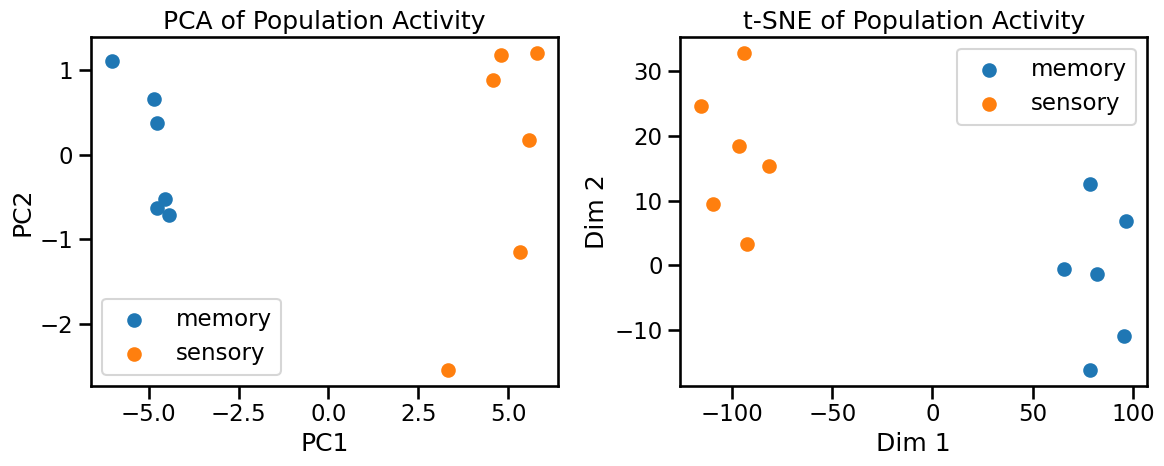

In [ ]:
plt.figure(figsize=(12, 5))

# PCA plot
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label)
plt.title('PCA of Population Activity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label)
plt.title('t-SNE of Population Activity')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend()

plt.tight_layout()
plt.show()
